# Running the Tabula Sapiens with all the data with Scanpy scoring.
                     
# INPUT: 

    * data/test_data/TabulaSapiens_subset.h5ad

# OUTPUT: 

    * data/test_data/scanpy_tabula_results.pkl

# Environment Setup

In [1]:
work_dir = '../../' #CHange to where git clone Cytocipher_manuscript/
import os
os.chdir(work_dir)

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt

import utils.visualisation.helpers as vhs
import utils.visualisation.quick_plots as qpl
qpl.setUp()

import seaborn as sb
from matplotlib_venn import venn2

pre_dir = '/media/WorkingSpace/Share/hypo_atlas/'
data_dir = pre_dir+'data/test_data/'
out_dir = data_dir

import cytocipher as cc
import importlib as imp

import cytocipher.score_and_merge.cluster_merge as cm
import cytocipher.score_and_merge.cluster_score as cs
imp.reload(cm)
imp.reload(cs)

import utils.preprocessing.load_data.simple_pickle as spl

# Loading the data

In [4]:
method = 'scanpy'

In [2]:
data = sc.read_h5ad(data_dir+'TabulaSapiens_subset.h5ad')

In [3]:
data.shape

(7385, 2435)

## Now let's run using Code-scoring to get p-values..

In [10]:
import psutil

def get_process_memory():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss

In [11]:
def scanpy_merge(data, cluster_key, marker_key,
                 k=15, mnn_frac_cutoff=None, random_state=20, p_cut=0.01, score_group_method='quantiles',
                 p_adjust=True, p_adjust_method='fdr_bh'):
    
    ### Scanpy-scoring.
    scanpy_scores = np.zeros((data.shape[0], len(data.uns[marker_key])))
    for i, group in enumerate(data.uns[marker_key]):
        sc.tl.score_genes(data, data.uns[marker_key][group])
        scanpy_scores[:,i] = data.obs['score'].values
    scanpy_scores = pd.DataFrame(scanpy_scores, index=data.obs_names, columns = list(data.uns[marker_key].keys()))
    data.obsm[f'{cluster_key}_enrich_scores'] = scanpy_scores
    
    ### Merging by Scanpy-score.
    cm.merge_clusters_single(data, cluster_key, f'{cluster_key}_merged',
                            k=k, mnn_frac_cutoff=mnn_frac_cutoff, random_state=random_state,
                          p_cut=p_cut,
                          score_group_method=score_group_method,
                          p_adjust=p_adjust, p_adjust_method=p_adjust_method,
                          verbose=False)

In [ ]:
##### Now re-running with the coexpr scoring...
import time
import tracemalloc
start = time.time()
start_mem = get_process_memory()
tracemalloc.start()
# cc.tl.merge_clusters(data, 'overclusters', var_groups='highly_variable', n_cpus=15, max_iter=0,
#                      enrich_method='code', 
#                       k=None, squash_exception=True,
#                      )
scanpy_merge(data, 'overclusters', 'overclusters_markers', k=None)
file_ = open(data_dir+f'tabula_{method}-mem.txt', 'w')
print(tracemalloc.get_traced_memory(), file=file_)
tracemalloc.stop()
end = time.time()
end_mem = get_process_memory()

In [13]:
lapse = end-start
print("Time in seconds: ", lapse, file=file_)
lapse_mem = end_mem - start_mem
print("Memory used: ", lapse_mem, file=file_)
file_.close()

In [5]:
!cat {data_dir}tabula_{method}-mem.txt

(156889598, 512800085)
Time in seconds:  3133.332538127899
Memory used:  14389248


In [6]:
(512800085-156889598)/1e6

355.910487

In [7]:
3133.332538127899/60

52.22220896879832

In [17]:
##### Cacheing results from Coexpr-scoring
enrich = method
results = {'enrich': enrich}
results[f'overclusters_{enrich}_scores'] = data.obsm[f'overclusters_enrich_scores']
results[f'overclusters_merged_{enrich}_scores'] = data.obsm[f'overclusters_merged_enrich_scores']
results[f'overclusters_{enrich}_merged'] = data.obs['overclusters_merged']
uns_keys = [key for key in data.uns.keys() if key.startswith('overclusters_')]
for key in uns_keys:
    results[f'{key}_{enrich}'] = data.uns[key]

In [25]:
?cc.pl.enrich_heatmap

/home/s4392586/myPython/Cytocipher/cytocipher/plotting/cluster_diagnostics.py:111: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  score_data = sc.AnnData(cell_scores_df, obs=data.obs)
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/plotting/_baseplot_class.py:122: UserWarning: Over 500 categories found. Plot would be very large.
  warn(


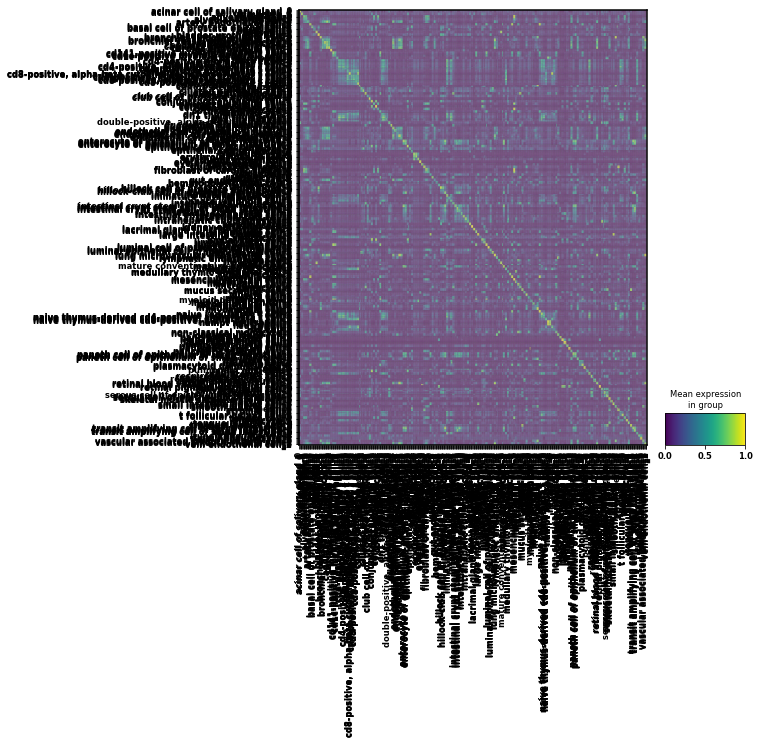

In [28]:
cc.pl.enrich_heatmap(data, 'overclusters', per_cell=False, scale_cols=False, scale_rows=True)

In [19]:
### Saving these results as a pickle object
spl.saveAsPickle(data_dir+f'{enrich}_tabula_results.pkl', results)